In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import json
import numpy as np
from shapely.geometry import Point, Polygon
from utils.geo_plot import setup_ax, plot_locs

from typing import Dict, Iterable, List, Optional

import importlib
import preprocessing.create_folds_b
importlib.reload(preprocessing.create_folds_b)

<module 'preprocessing.create_folds_b' from 'c:\\Users\\Benjamin\\Desktop\\Exjobb\\CreateFolds\\preprocessing\\create_folds_b.py'>

# Read data and remove points to break cluster chains

In [2]:
dhs_df_og = pd.read_csv('../dhs_clusters.csv', float_precision='high', index_col=False)

dhs_locs = dhs_df_og[['lat', 'lon']].values

#fold_names = ['A', 'B', 'C', 'D', 'E']
fold_names = ['90-95', '96-01', '02-07', '08-13', '14-19']


In [3]:
# Read regions to remove from JSON
with open('remove_regions2.json') as f:
    remove_regions_gj = json.load(f)

# Create polygon regions to remove points within
remove_regions = []
for region in remove_regions_gj['features']:
    remove_regions.append(Polygon(region['geometry']['coordinates'][0]))

# Method to determine whether point lies within polygon or not
def in_polys(point, polys):
  for poly in polys:
    if point.within(poly):
      return True
  return False

# Remove points within polygons
dhs_df = dhs_df_og.copy()
dhs_df['geometry'] = dhs_df_og.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
dhs_df = dhs_df[~(dhs_df['geometry'].apply(lambda p: in_polys(p, remove_regions)))]

dhs_df = dhs_df.drop(columns='geometry')
dhs_df.head()

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi
0,angola,2015,-8.589805,13.640789,AGO.1,AGO.1.2,21,0,62.334459
1,angola,2016,-7.718385,14.122619,AGO.1,AGO.1.5,9,1,8.226589
2,angola,2015,-8.592545,13.654425,AGO.1,AGO.1.2,19,0,62.760211
3,angola,2016,-8.652260,13.517859,AGO.11,AGO.11.1,12,1,68.211697
4,angola,2015,-7.852511,13.721998,AGO.1,AGO.1.1,15,1,14.825944


In [4]:
print(len(dhs_df))
print(len(dhs_df_og))

56776
57195


# Plotting and helper methods

In [5]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

In [6]:
def plot_iwi_distribution(dhs_df, folds, plot_title):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(20, 10), dpi=80)
    fig, axes=plt.subplots(1,1, figsize=(20,10))
    for i, fold in enumerate(folds.keys()):
        x = dhs_df['iwi'].loc[folds[fold]].values
        plt.axvline(x=np.mean(x), color=colors[i], alpha=0.4)
        ax=sns.kdeplot(data=x, color=colors[i])
        
        print("fold {} - MEAN: ".format(fold), np.mean(x), ", STD DEV: ", np.std(x))

    fig.legend(labels=folds.keys(), prop={'size': 20})
    ax.yaxis.label.set_size(24)
    ax.xaxis.label.set_size(24)
    plt.xticks(fontsize=22, rotation=90)
    plt.yticks(fontsize=18, rotation=90)
    plt.xlabel('IWI')
    plt.ylabel('Density')
    plt.title(plot_title, fontsize=22)

    plt.show()

In [23]:
def select_representative_fold(df_train_val, folds, prints=False):
    means = {f: df_train_val['iwi'].loc[folds[f]].mean() for f in folds.keys()}
    mean_tot = df_train_val['iwi'].mean()
    mean_diff = {f: abs(means[f] - mean_tot) for f in folds.keys()}

    stds = {f: df_train_val['iwi'].loc[folds[f]].std() for f in folds.keys()}
    std_tot = df_train_val['iwi'].std()
    std_diff = {f: abs(stds[f] - std_tot) for f in folds.keys()}

    # Weigh having correct mean more important than standard deviation
    tot_diff = {f: mean_diff[f] + std_diff[f]/2 for f in folds.keys()}
    val_fold = min(tot_diff, key=tot_diff.get)

    if prints:
        print("MEANS: ")
        print("Folds: ", means)
        print("Total: ", mean_tot)
        print("Diff: ", mean_diff)
        print()
        print("STDS: ")
        print("Folds: ", stds)
        print("Total: ", std_tot)
        print("Diff: ", std_diff)
        print()
        print("TOTAL DIFF SCORE: ", tot_diff)
        print()
        print("Most representative fold: ", val_fold)


    return val_fold

In [7]:
def divide_safely_by_zero(x, y):
    if y == 0:
        return 0
    else:
        return x / y

## Creating .py-method


In [19]:
dhs_df.head()
grouped = dhs_df.groupby('year')
year_indices_dict = grouped.groups

year_indices_dict[1991]


timespan_indices: Dict[str, List[int]] = {f: [] for f in fold_names}
timespan_indices

#timespan_indices[fold_names[0]].extend(year_indices_dict[1991])
#timespan_indices[fold_names[0]].extend(year_indices_dict[1992])

fold_names = ['90-95', '96-01', '02-07', '08-13', '14-19']
#timespan_indices['90-95'].extend([year_indices_dict[1991], year_indices_dict[1992], year_indices_dict[1993], year_indices_dict[1994], year_indices_dict[1995]])
timespan_indices['90-95'].extend(year_indices_dict[1991])
timespan_indices['90-95'].extend(year_indices_dict[1992])
timespan_indices['90-95'].extend(year_indices_dict[1993])
timespan_indices['90-95'].extend(year_indices_dict[1994])
timespan_indices['90-95'].extend(year_indices_dict[1995])

timespan_indices['96-01'].extend(year_indices_dict[1996])
timespan_indices['96-01'].extend(year_indices_dict[1997])
timespan_indices['96-01'].extend(year_indices_dict[1998])
timespan_indices['96-01'].extend(year_indices_dict[1999])
timespan_indices['96-01'].extend(year_indices_dict[2000])
timespan_indices['96-01'].extend(year_indices_dict[2001])

#timespan_indices['02-07'].extend(year_indices_dict[2002])
timespan_indices['02-07'].extend(year_indices_dict[2003])
timespan_indices['02-07'].extend(year_indices_dict[2004])
timespan_indices['02-07'].extend(year_indices_dict[2005])
timespan_indices['02-07'].extend(year_indices_dict[2006])
timespan_indices['02-07'].extend(year_indices_dict[2007])

timespan_indices['08-13'].extend(year_indices_dict[2008])
timespan_indices['08-13'].extend(year_indices_dict[2009])
timespan_indices['08-13'].extend(year_indices_dict[2010])
timespan_indices['08-13'].extend(year_indices_dict[2011])
timespan_indices['08-13'].extend(year_indices_dict[2012])
timespan_indices['08-13'].extend(year_indices_dict[2013])

timespan_indices['14-19'].extend(year_indices_dict[2014])
timespan_indices['14-19'].extend(year_indices_dict[2015])
timespan_indices['14-19'].extend(year_indices_dict[2016])
timespan_indices['14-19'].extend(year_indices_dict[2017])
timespan_indices['14-19'].extend(year_indices_dict[2018])
timespan_indices['14-19'].extend(year_indices_dict[2019])



#timespan = 0
#counter = 0
#for year in year_indices_dict:
#    
#    if year == 1991 or year == 1992:
#        continue
#
#    if counter % 6 == 0:
#        timespan += 1
#        print("year: ", year, " timespan: ", timespan)
#        if year == 2003:
#            counter += 1
#        
#    
#    timespan_indices[fold_names[timespan]].extend(year_indices_dict[year])
#    
#    counter += 1
#    print(year)
#    

print(len(timespan_indices['90-95']))

print(len(timespan_indices['96-01']))
print(len(timespan_indices['02-07']))
print(len(timespan_indices['08-13']))
print(len(timespan_indices['14-19']))

3050
5764
9846
18396
19720


FOLD SIZES:
90-95 :  3050
96-01 :  5764
02-07 :  9846
08-13 :  18396
14-19 :  19720


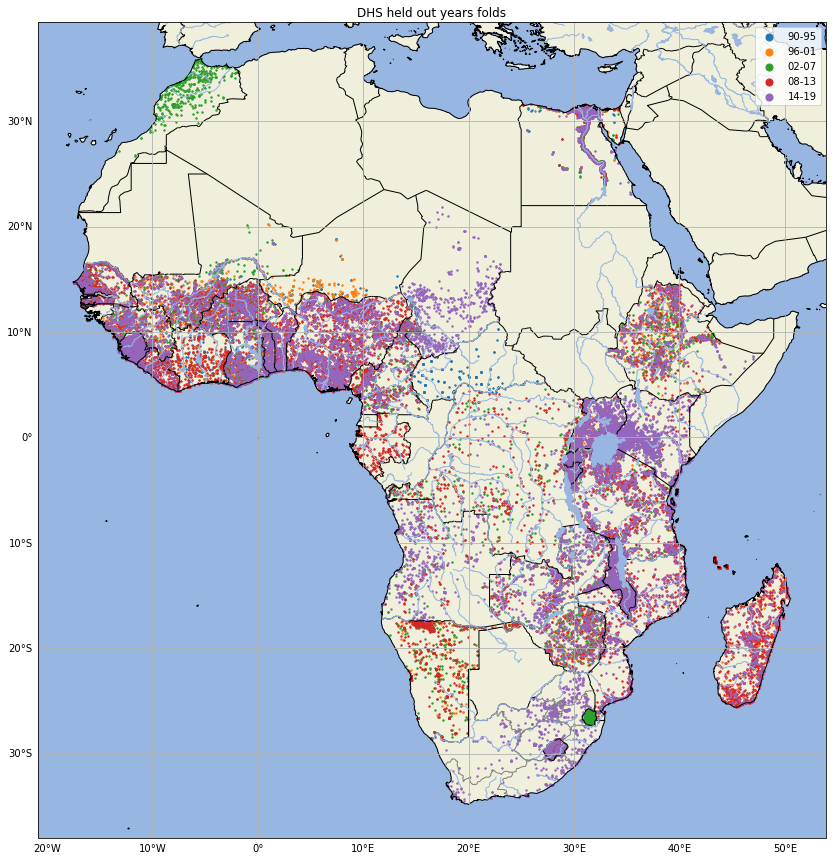

fold 90-95 - MEAN:  34.66501011598732 , STD DEV:  16.978953565752366
fold 96-01 - MEAN:  27.68146044146195 , STD DEV:  17.832723539870557
fold 02-07 - MEAN:  34.134917457386386 , STD DEV:  20.785470374734892
fold 08-13 - MEAN:  29.917548462488377 , STD DEV:  18.50877692530064
fold 14-19 - MEAN:  34.007870404730326 , STD DEV:  19.870914474021625


<Figure size 1600x800 with 0 Axes>

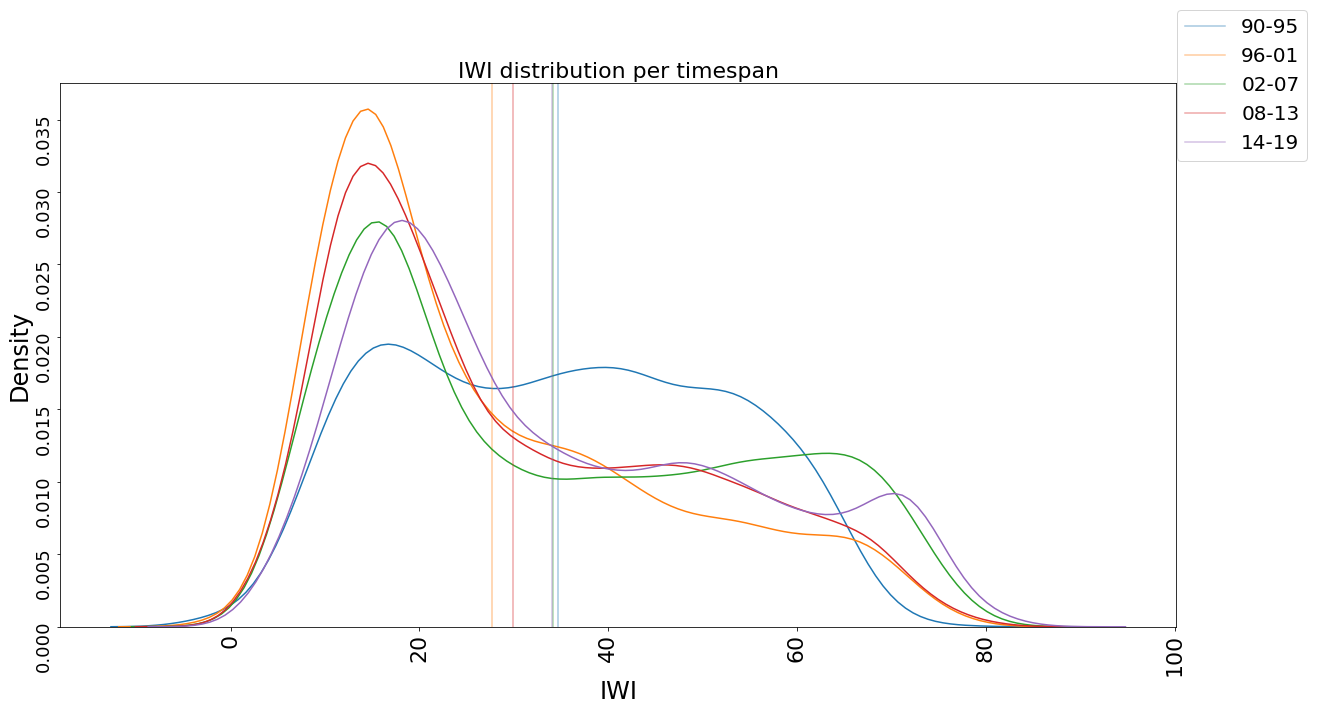

In [21]:
print("FOLD SIZES:")
for timespan in timespan_indices:
    print(timespan, ": ", len(timespan_indices[timespan]))

plot_splits({f: dhs_locs[timespan_indices[f]] for f in fold_names},
            title='DHS held out years folds')
            
plot_iwi_distribution(dhs_df, timespan_indices, plot_title='IWI distribution per timespan')


## Create train and validation sets for each test fold

FOLD:  90-95
num clusters: 4318
num outliers: 7835
max cluster size (excl. outliers): 1963


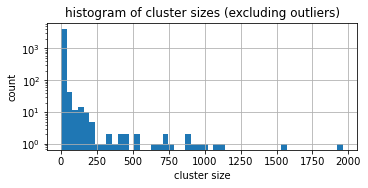

fold 1 - MEAN:  31.978673297635304 , STD DEV:  20.263990543433888
fold 2 - MEAN:  32.08847034542595 , STD DEV:  18.830175424397762
fold 3 - MEAN:  31.86326520551535 , STD DEV:  19.412112360840897
fold 4 - MEAN:  31.877135680006035 , STD DEV:  19.575807314903447


<Figure size 1600x800 with 0 Axes>

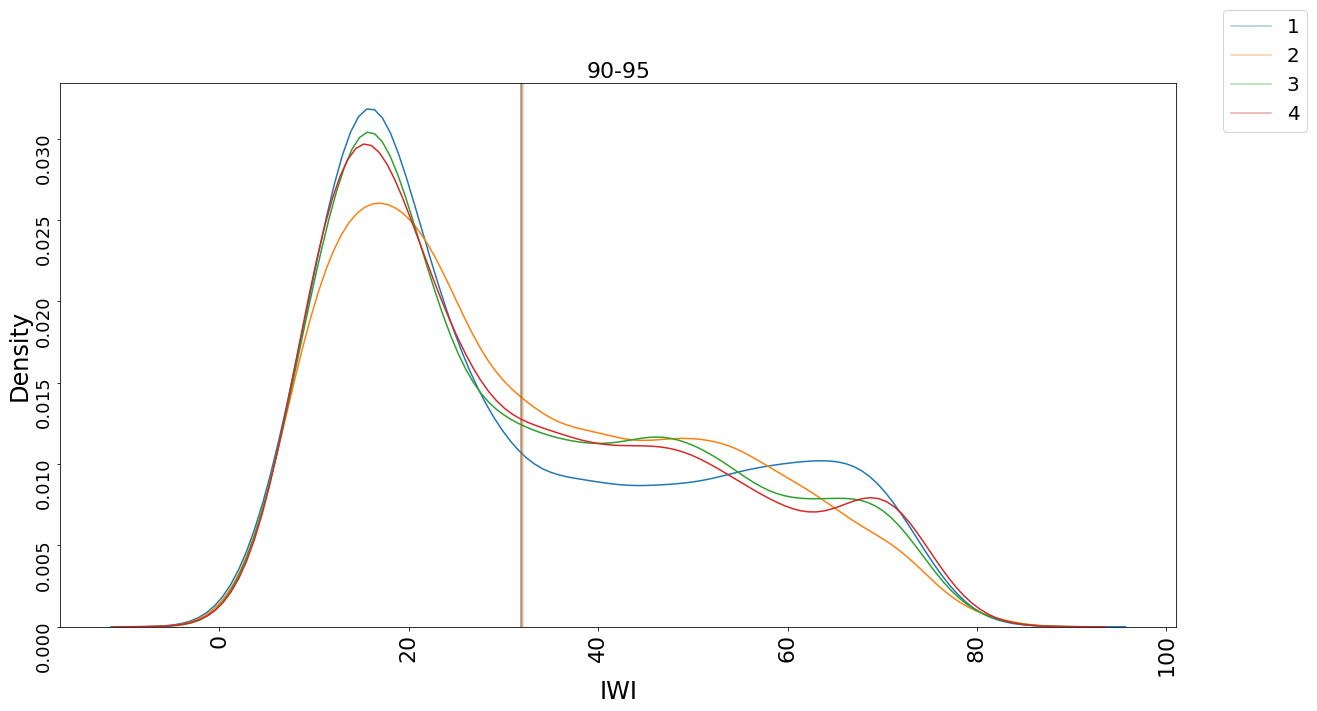

VAL FOLD:  4
_____________________
FOLD:  96-01
num clusters: 4135
num outliers: 7801
max cluster size (excl. outliers): 1869


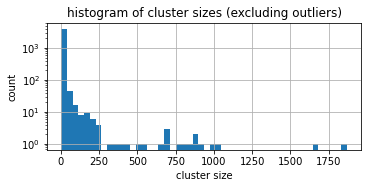

fold 1 - MEAN:  32.796795094388735 , STD DEV:  20.39323194004306
fold 2 - MEAN:  32.694492648289774 , STD DEV:  20.090514063291188
fold 3 - MEAN:  32.47169026661503 , STD DEV:  18.30436380333259
fold 4 - MEAN:  32.423590221597436 , STD DEV:  19.205696435574104


<Figure size 1600x800 with 0 Axes>

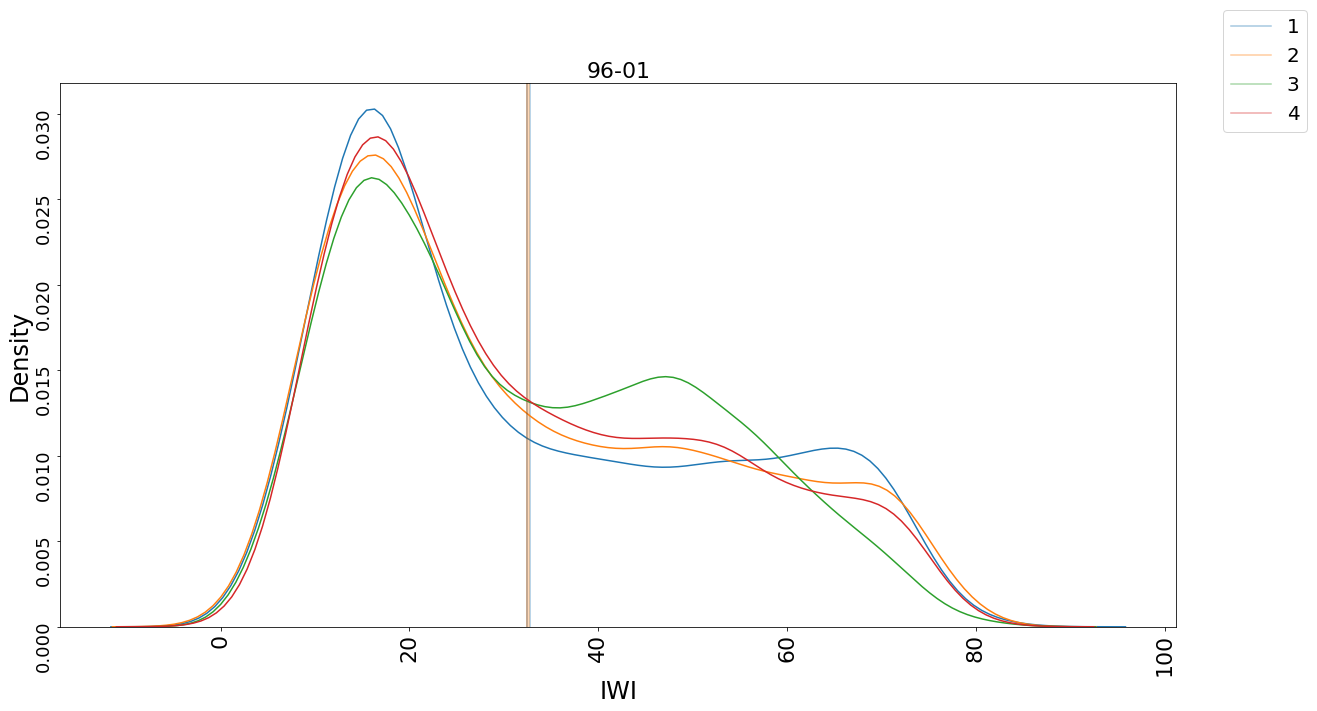

VAL FOLD:  4
_____________________
FOLD:  02-07
num clusters: 3929
num outliers: 7388
max cluster size (excl. outliers): 1492


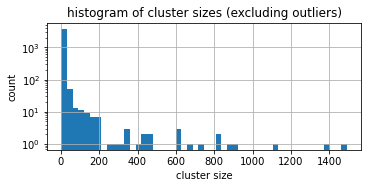

fold 1 - MEAN:  31.859587132682233 , STD DEV:  19.964982282171317
fold 2 - MEAN:  31.472790235408926 , STD DEV:  17.70246987314914
fold 3 - MEAN:  31.90804656778214 , STD DEV:  19.786366966793224
fold 4 - MEAN:  31.440430136290818 , STD DEV:  18.77437020149716


<Figure size 1600x800 with 0 Axes>

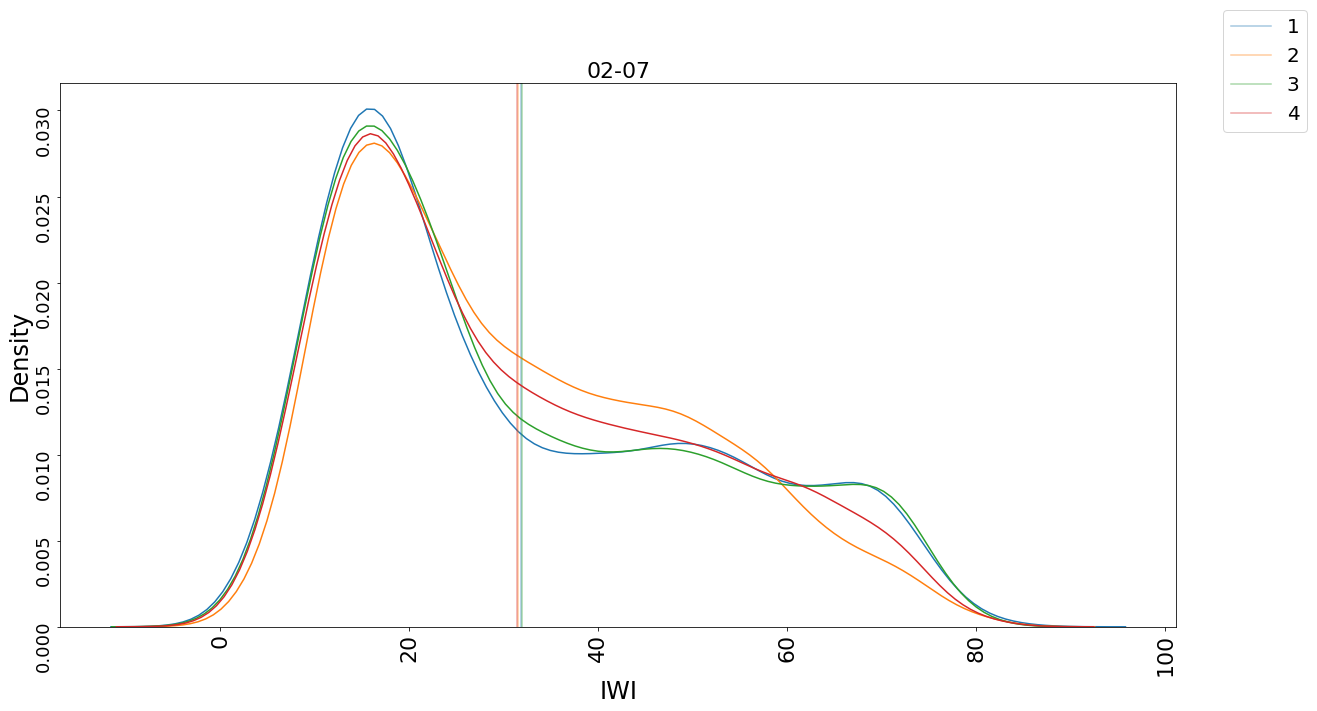

VAL FOLD:  4
_____________________
FOLD:  08-13
num clusters: 3258
num outliers: 6969
max cluster size (excl. outliers): 1600


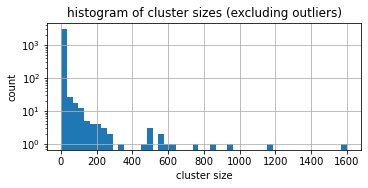

fold 1 - MEAN:  33.48606229828299 , STD DEV:  20.135256329190046
fold 2 - MEAN:  33.01118134957926 , STD DEV:  20.351745658307316
fold 3 - MEAN:  33.04422877283524 , STD DEV:  18.816205158003946
fold 4 - MEAN:  33.02894908349692 , STD DEV:  19.61906511880382


<Figure size 1600x800 with 0 Axes>

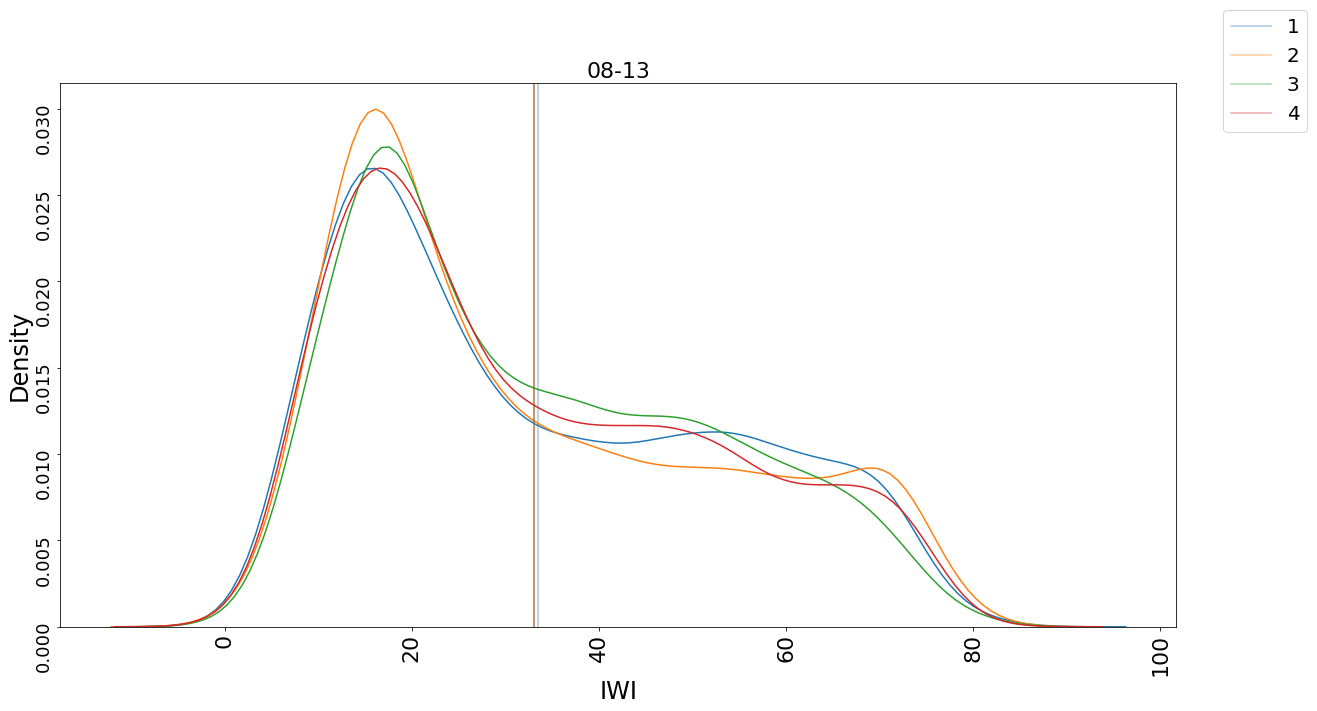

VAL FOLD:  4
_____________________
FOLD:  14-19
num clusters: 3275
num outliers: 6586
max cluster size (excl. outliers): 1487


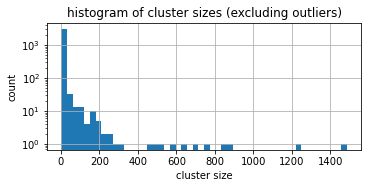

fold 1 - MEAN:  31.137927792453517 , STD DEV:  19.662480383654202
fold 2 - MEAN:  31.033645665374564 , STD DEV:  19.74970820696957
fold 3 - MEAN:  30.970174182936777 , STD DEV:  18.188722775212376
fold 4 - MEAN:  31.18247584958691 , STD DEV:  18.673663738048653


<Figure size 1600x800 with 0 Axes>

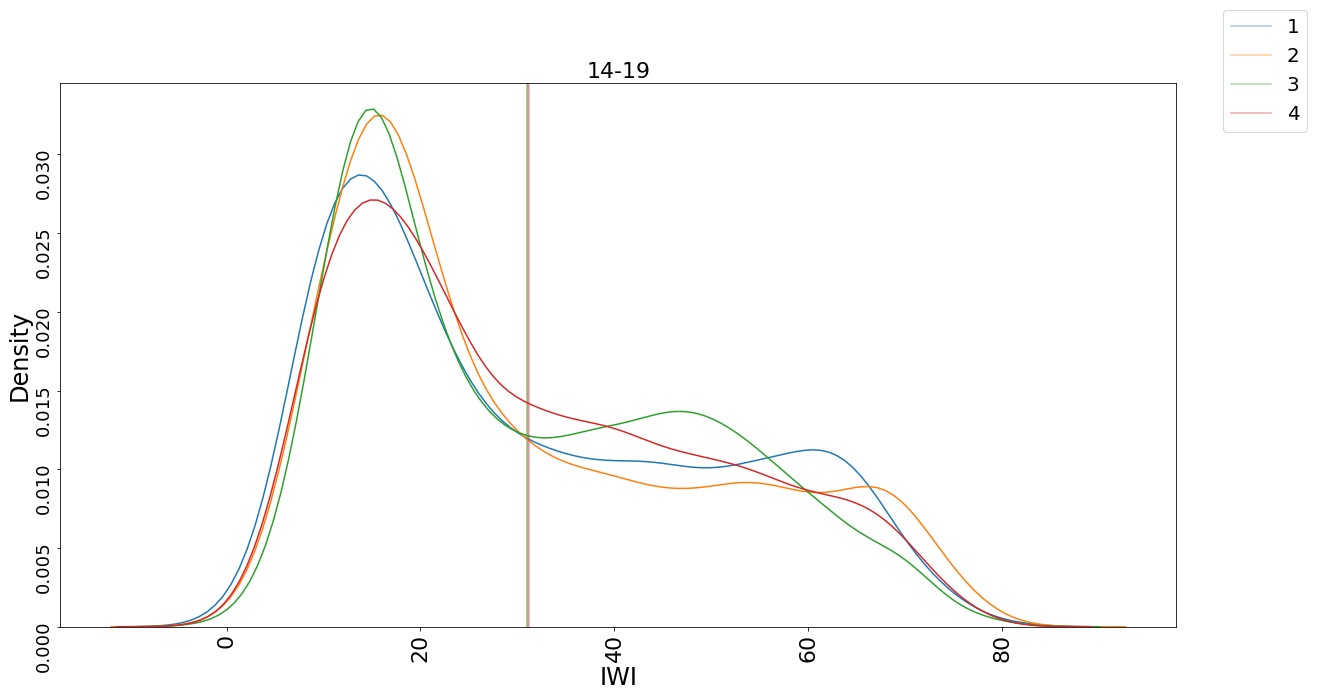

VAL FOLD:  4
_____________________
90-95 :  train :  40294
90-95 :  val :  13432
90-95 :  test :  3050

96-01 :  train :  38258
96-01 :  val :  12754
96-01 :  test :  5764

02-07 :  train :  35197
02-07 :  val :  11733
02-07 :  test :  9846

08-13 :  train :  28784
08-13 :  val :  9596
08-13 :  test :  18396

14-19 :  train :  27792
14-19 :  val :  9264
14-19 :  test :  19720



In [24]:
# country_folds: TEST FOLDS
# dhs_df

importlib.reload(preprocessing.create_folds_b)

# DOES NOT WORK WITH FRACTIONS
split_folds = {}
for test_fold in timespan_indices.keys():
    print("FOLD: ", test_fold)

    split_folds[test_fold] = {}

    # Create new DataFrame with just train and val data
    train_val_indices = np.setdiff1d(dhs_df.index.values, timespan_indices[test_fold])
    df_train_val = dhs_df.loc[train_val_indices]

    # Create four folds from train and val data
    #train_val_fold_names = list(timespan_indices.keys())
    #train_val_fold_names.remove(test_fold)
    train_val_fold_names = ['1', '2', '3', '4']
    train_val_folds = preprocessing.create_folds_b.create_folds(df=df_train_val, fold_names=train_val_fold_names, random_state=1338, big_fold_penalty=150)

    plot_iwi_distribution(df_train_val, train_val_folds, test_fold)

    val_fold = select_representative_fold(df_train_val, train_val_folds)
    print("VAL FOLD: ", val_fold)
    #train_folds = train_val_fold_names.remove(val_fold)

    # Assign test data
    split_folds[test_fold]['test'] = timespan_indices[test_fold]

    # Assign validation data
    split_folds[test_fold]['val'] = train_val_folds[val_fold]
    
    # Assign training data
    train_indices = np.setdiff1d(train_val_indices, train_val_folds[val_fold])
    split_folds[test_fold]['train'] = train_indices

    print("_____________________")

for fold in fold_names:
    for dataset in ['train', 'val', 'test']:
        print(fold, ": ", dataset, ": ", len(split_folds[fold][dataset]))
    print()



# Save folds to pkl-file

In [25]:
# SAVE FOLDS
preprocessing.create_folds_b.save_folds(
   folds_path='held_out_years_5_folds.pkl',
   folds=split_folds,
   check_exists=False)

In [27]:
with open('held_out_years_5_folds.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())

for i in data.keys():
    print(i)

print(data['14-19'].keys())

print(len(data['14-19']['test']))

dict_keys(['90-95', '96-01', '02-07', '08-13', '14-19'])
90-95
96-01
02-07
08-13
14-19
dict_keys(['test', 'val', 'train'])
19720


In [33]:
with open('new_dhs_incountry_folds.pkl', 'rb') as f:
    data = pickle.load(f)

data.keys()

data['A']['test']

array([   18,    23,    29, ..., 57192, 57193, 57194])

In [37]:
dhs_df_og.loc[data['A']['test']]

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi
18,angola,2016,-8.247006,13.693179,AGO.1,AGO.1.2,18,1,14.052838
23,angola,2016,-8.849448,13.745452,AGO.1,AGO.1.2,15,1,11.126701
29,angola,2015,-8.717116,14.803289,AGO.6,AGO.6.4,24,1,3.669306
41,angola,2016,-12.490435,14.578187,AGO.2,AGO.2.2,19,1,4.117757
43,angola,2015,-12.589898,13.389090,AGO.2,AGO.2.3,20,0,60.324745
...,...,...,...,...,...,...,...,...,...
57188,zimbabwe,2015,-19.443993,29.790168,ZWE.10,ZWE.10.4,26,0,55.455397
57189,zimbabwe,2015,-18.884490,29.854579,ZWE.10,ZWE.10.5,27,0,60.298870
57192,zimbabwe,2015,-20.724753,30.172833,ZWE.10,ZWE.10.6,27,1,24.406326
57193,zimbabwe,2015,-19.453466,29.820084,ZWE.10,ZWE.10.4,28,0,59.887344


: 